# Conditional GAN
Training a model to generate pokemon based on their shape.

Conditional GAN articles:
- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
- https://arxiv.org/abs/1411.1784

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from helper import *

In [7]:
data_dir = "../data"
image_dir = data_dir + '/' + "images"
data_table = load_index_table()

In [8]:
data_table

,national_index,image_file,pokemon_name,type_1,type_2,shape
0,90,090MS.png,shellder,water,NaN,pokemon consisting of only a head
1,91,091XYMS.png,cloyster,water,ice,pokemon consisting of only a head
2,92,092MS.png,gastly,ghost,poison,pokemon consisting of only a head
3,100,100MS.png,voltorb,electric,NaN,pokemon consisting of only a head
4,101,101MS.png,electrode,electric,NaN,pokemon consisting of only a head
...,...,...,...,...,...,...
904,787,787MS.png,tapu bulu,grass,fairy,pokemon consisting of a head and arms
905,788,788MS.png,tapu fini,water,fairy,pokemon consisting of a head and arms
906,800,800MS.png,necrozma,psychic,NaN,pokemon consisting of a head and arms
907,864,864MS.png,cursola,ghost,NaN,pokemon consisting of a head and arms


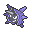

In [9]:
file = image_dir + "/091XYMS.png"
image = load_image(file, image_preprocessing)
image

In [10]:
image.size

(32, 32)

In [11]:
labels = data_table["shape"].unique()
labels

array(['pokemon consisting of only a head',
       'pokemon consisting of a head and legs', 'pokemon with fins',
       'pokemon with an insectoid body', 'pokemon with a quadruped body',
       'pokemon with two or more pairs of wings',
       'pokemon consisting of multiple bodies',
       'pokemon with tentacles or a multiped body',
       'pokemon consisting of a head and a base',
       'pokemon with a bipedal tailed form',
       'pokemon with a bipedal tailless form',
       'pokemon with a single pair of wings',
       'pokemon with serpentine bodies',
       'pokemon consisting of a head and arms'], dtype=object)

In [12]:
label_mapping = {k:v for v, k in enumerate(labels)}
inverse_mapping = {v: k for k, v in label_mapping.items()}
label_mapping

{'pokemon consisting of only a head': 0,
 'pokemon consisting of a head and legs': 1,
 'pokemon with fins': 2,
 'pokemon with an insectoid body': 3,
 'pokemon with a quadruped body': 4,
 'pokemon with two or more pairs of wings': 5,
 'pokemon consisting of multiple bodies': 6,
 'pokemon with tentacles or a multiped body': 7,
 'pokemon consisting of a head and a base': 8,
 'pokemon with a bipedal tailed form': 9,
 'pokemon with a bipedal tailless form': 10,
 'pokemon with a single pair of wings': 11,
 'pokemon with serpentine bodies': 12,
 'pokemon consisting of a head and arms': 13}

### Transforms

In [13]:
use_color = True
n_channels = 3 if use_color else 1
if use_color:
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])
else:
    data_transforms = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

In [14]:
ds = IndexDataset(
    data_table,
    image_dir,
    label_mapping=label_mapping,
    image_transform=image_preprocessing,
    torch_transforms=data_transforms
)

In [15]:
# Dataloader
batch_size = 16
shuffle = True
training_dataloader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

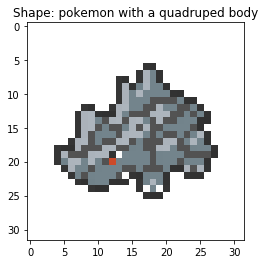

In [16]:
test_batch_images, test_batch_labels = next(iter(training_dataloader))
image_sample = test_batch_images[0]
label_sample = test_batch_labels[0]
image_sample = image_sample.permute(1, 2, 0)
if not use_color:
    image_sample = image_sample.squeeze()
plt.title(f"Shape: {inverse_mapping[label_sample.item()]}")
plt.imshow(image_sample)
plt.show()

In [64]:
# image is from above
image_w, image_h = image.size
noise_size = 100
n_labels = len(label_mapping)
label_embedding = 250
G = CGAN(n_labels, noise_size, image_w, image_h, label_embedding)
G

CGAN(
  (embedding): Embedding(14, 250)
  (proj1): Linear(in_features=250, out_features=1024, bias=True)
  (proj2): Linear(in_features=100, out_features=200, bias=True)
  (proj3): Linear(in_features=200, out_features=1024, bias=True)
  (proj4): Linear(in_features=2048, out_features=2048, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.1)
  (deconv_layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (final_conv): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [65]:
G.init_weights()

In [66]:
D = CDim(n_labels, label_embedding, image_w, image_h)
D

CDim(
  (lrelu): LeakyReLU(negative_slope=0.1)
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (noise): GaussianNoise()
  (embedding): Embedding(14, 250)
  (proj1): Linear(in_features=250, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [67]:
D.init_weights()

### Optimisers

In [68]:
# learning rate for optimizers
lr_d = 0.0004
lr_g = 0.0001

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))

## Training

In [ ]:
# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
all_samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
sample_z = generate_random((sample_size, noise_size))
sample_z = torch.from_numpy(sample_z).float()
sample_labels = torch.randint(low=0, high=len(label_mapping), size=(sample_size, 1), dtype=torch.long)

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, labels) in enumerate(training_dataloader):                
        batch_size = real_images.size(0)
        real_images = scale(real_images, min_val=-1.0, max_val=1.0)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        batch_out_real = D(real_images, labels)
        d_real_loss = real_loss(batch_out_real, smooth=True)
        
        # 2. Train with fake images
        # Generate fake images
        z = generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z, labels)
        
        # Compute the discriminator losses on fake images        
        
        # add up real and fake losses and perform backprop
        batch_out_fake = D(fake_images, labels)
        d_fake_loss = fake_loss(batch_out_fake)
    
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        g_loss = real_loss(batch_out_fake)
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples = G(sample_z, sample_labels)
    all_samples.append(samples)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

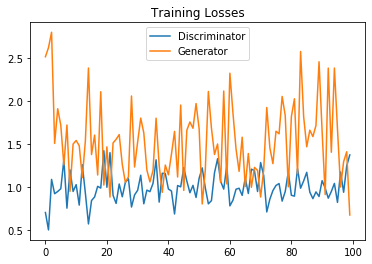

In [70]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling

In [86]:
def reshape_sample(samples, img_size, is_rgb=True):
    samples = (samples + 1) / 2  # Reverse scaling
    samples = samples.permute(0, 2, 3, 1)
    samples.detach()
    return samples.numpy()

In [91]:
# randomly generated, new latent vectors
sample_size=16
rand_z = generate_random((sample_size, noise_size))
rand_z = torch.from_numpy(rand_z).float()
rand_label = np.random.randint(0, len(label_mapping))
rand_labels = torch.zeros((sample_size, 1), dtype=torch.long) + rand_label
G.eval() # eval mode
# generated samples
with torch.no_grad():
    rand_images = G(rand_z, rand_labels)
    
reshaped_images = reshape_sample(rand_images, image_w, is_rgb=use_color).squeeze()

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.title(f"Samples for {inverse_mapping[rand_label]}")
for i, s in enumerate(reshaped_images):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(s, cmap='gray')